# ☘️ SKIN DISEASE CLASSIFICATION USING RESNET-9 ☘️

##### ⚠️⚠️⚠️DISCLAIMER: This notebook is beginner friendly, so don't worry if you don't know much about CNNs and Pytorch. Even if you have used TensorFlow in the past and are new to PyTorch, hang in there, everything is explained clearly and concisely. You will get a good overview of how to use PyTorch for image classification problems.

# Description of the dataset 📝

This dataset is created using offline augmentation from the original dataset. The original PlantVillage Dataset can be found [here](https://github.com/spMohanty/PlantVillage-Dataset).This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structure. A new directory containing 33 test images is created later for prediction purpose.

Note: This description is given in the dataset itself

# Our goal 🎯
Goal is clear and simple. We need to build a model, which can classify between healthy and diseased crop leaves and also if the crop have any disease, predict which disease is it.

##### Let's get started....

## Importing necessary libraries

Let's import required modules

In [5]:
!pip install torchsummary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


We would require torchsummary library to print the model's summary in keras style (nicely formatted and pretty to look) as Pytorch natively doesn't support that

In [6]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

# 🧭 Exploring the data 🧭

Loading the data 

In [7]:
data_dir = "../input/skin-data/data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/val"
diseases = os.listdir(train_dir)

In [8]:
# printing the disease names
print(diseases)

['Nail_psoriasis', 'acne', 'hyperpigmentation', 'SJS-TEN', 'Vitiligo']


In [9]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 5


So we have images of leaves of 14 plants and while excluding healthy leaves, we have 26 types of images that show a particular disease in a particular plant.

In [10]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Nail_psoriasis,2024
acne,918
hyperpigmentation,560
SJS-TEN,2531
Vitiligo,1613


#### Visualizing the above information on a graph

Text(0.5, 1.0, 'Images per each class of plant disease')

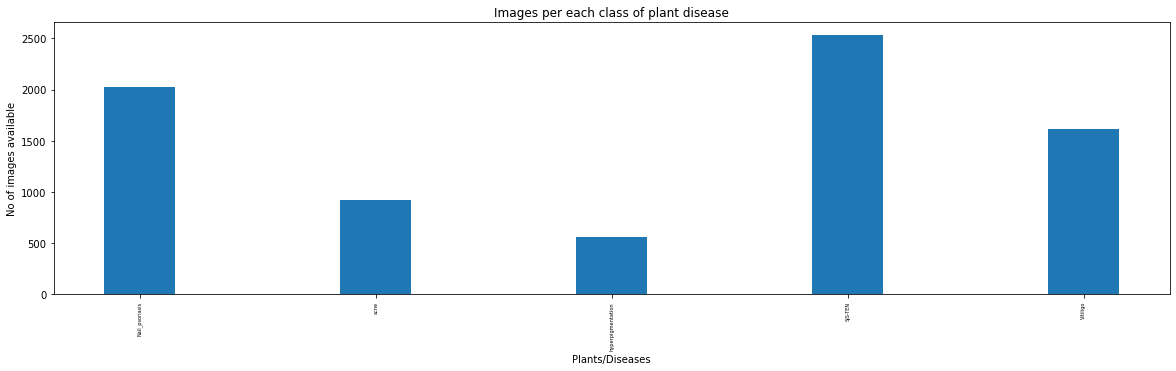

In [11]:
# plotting number of images available for each disease
index = [n for n in range(5)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

We can see that the dataset is almost balanced for all classes, so we are good to go forward

#### Images available for training

In [12]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 7646 images for training


# 🍳 Data Preparation for training 🍳

In [13]:
# datasets for validation and training
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor()
])
train = ImageFolder(train_dir, transform=transform)
valid = ImageFolder(valid_dir, transform=transform)

`torchvision.datasets` is a class which helps in loading all common and famous datasets. It also helps in loading custom datasets. I have used subclass `torchvision.datasets.ImageFolder` which helps in loading the image data when the data is arranged in this way:

----------------
root/dog/xxx.png

root/dog/xxy.png

root/dog/xxz.png

<br>

root/cat/123.png

root/cat/nsdf3.png

root/cat/asd932_.png

----------------

Next, after loading the data, we need to transform the pixel values of each image (0-255) to 0-1 as neural networks works quite good with normalized data. The entire array of pixel values is converted to torch [tensor](https://pytorch.org/tutorials/beginner/examples_tensor/two_layer_net_tensor.html#:~:text=A%20PyTorch%20Tensor%20is%20basically,used%20for%20arbitrary%20numeric%20computation.) and then divided by 255.
If you are not familiar why normalizing inputs help neural network, read [this](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d) post.

#### Image shape 

In [14]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


We can see the shape (3, 256 256) of the image. 3 is the number of channels (RGB) and 256 x 256 is the width and height of the image

In [15]:
# total number of classes in train set
len(train.classes)

5

In [16]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

## 🖼️ Some Images from training dataset 🖼️

Label :Nail_psoriasis(0)


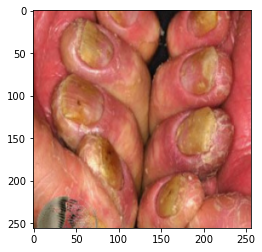

In [17]:
show_image(*train[0])

In [18]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [19]:
# setting the batch size
batch_size = 32

`batch_size` is the total number of images given as input at once in forward propagation of the CNN. Basically, batch size defines the number of samples that will be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network.

In [20]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

- `DataLoader` is a subclass which comes from `torch.utils.data`. It helps in loading large and memory consuming datasets. It takes in `batch_size` which denotes the number of samples contained in each generated batch. 

- Setting `shuffle=True` shuffles the dataset. It is heplful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.

- `num_workers`, denotes the number of processes that generate batches in parallel. If you have more cores in your CPU, you can set it to number of cores in your CPU. Since, Kaggle provides a 2 core CPU, I have set it to 2


In [21]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

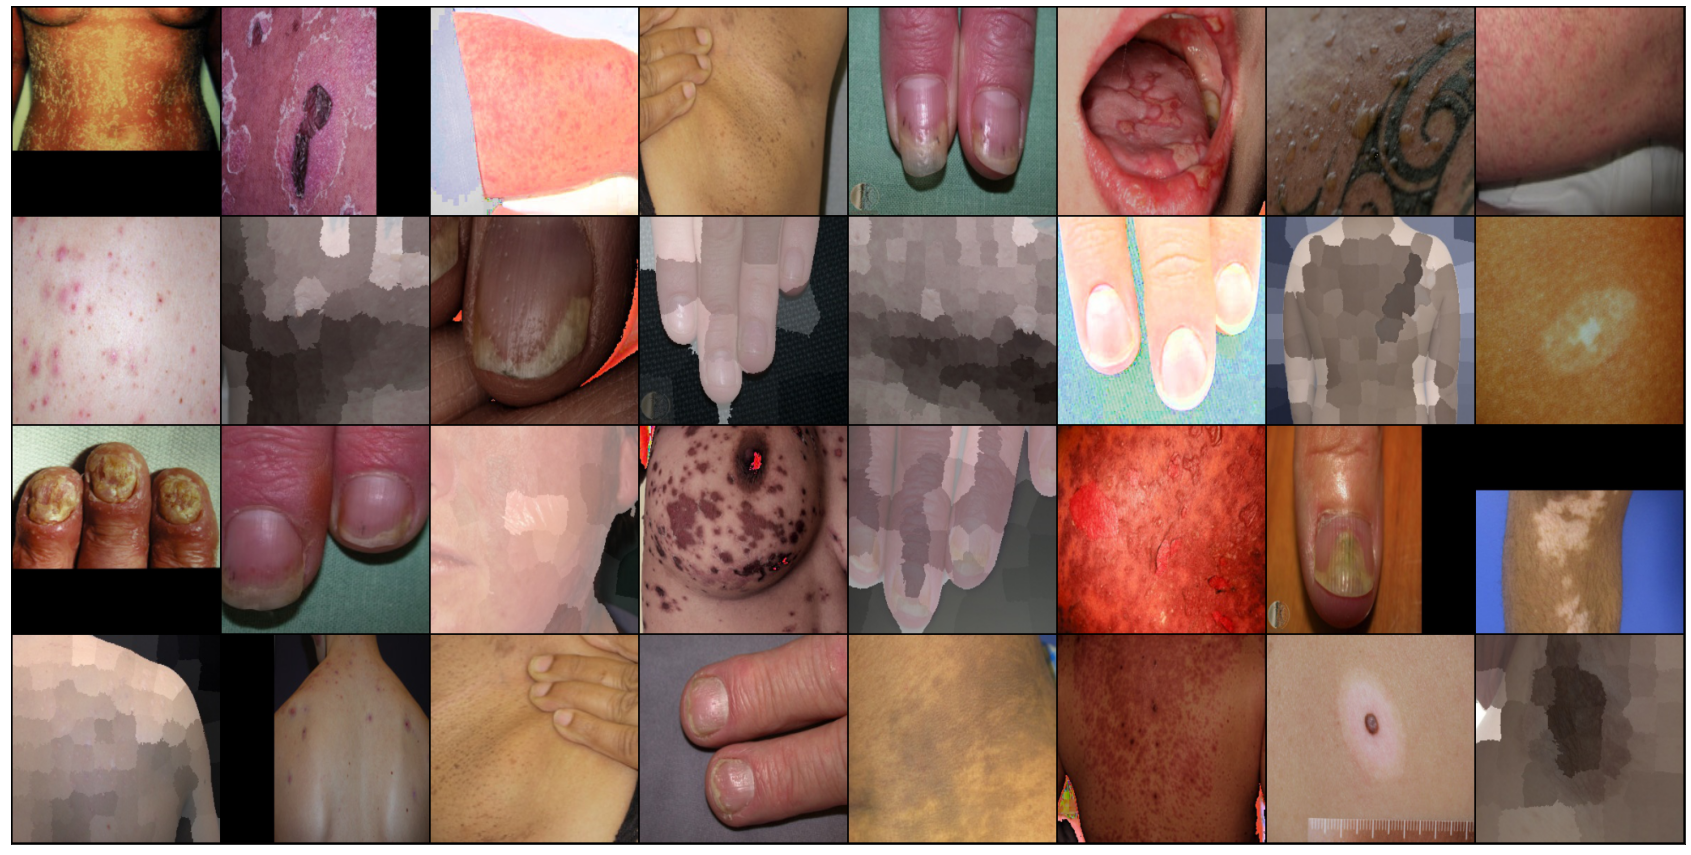

In [22]:
# Images for first batch of training
show_batch(train_dl) 

# 🏗️ Modelling 🏗️

It is advisable to use GPU instead of CPU when dealing with images dataset because CPUs are generalized for general purpose and GPUs are optimized for training deep learning models as they can process multiple computations simultaneously. They have a large number of cores, which allows for better computation of multiple parallel processes. Additionally, computations in deep learning need to handle huge amounts of data — this makes a GPU’s memory bandwidth most suitable.
To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required

#### Some helper functions

In [23]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Checking the device we are working with

In [24]:
device = get_default_device()
device

device(type='cuda')

Wrap up our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available)

In [25]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## 👷 Building the model architecture 👷

*We are going to use **ResNet**, which have been one of the major breakthrough in computer vision since they were introduced in 2015.*

If you want to learn more about ResNets read the following articles:
- [Understanding and Visualizing ResNets](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8#:~:text=ResNet%20Layers,layers%20remains%20the%20same%20%E2%80%94%204.)
- [Overview of ResNet and its variants](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)
- [Paper with code implementation](https://paperswithcode.com/method/resnet)

In ResNets, unlike in traditional neural networks, each layer feeds into the next layer, we use a network with residual blocks, each layer feeds into the next layer and directly into the layers about 2–3 hops away, to avoid over-fitting (a situation when validation loss stop decreasing at a point and then keeps increasing while training loss still decreases). This also helps in preventing [vanishing gradient problem](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484) and allow us to train deep neural networks. Here is a simple residual block:

![image](https://www.mdpi.com/remotesensing/remotesensing-11-01896/article_deploy/html/images/remotesensing-11-01896-g001.png)

#### Residual Block code implementation

In [26]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

**Then we define our `ImageClassificationBase` class whose functions are:**

- `training_step` - To figure out how “wrong” the model is going after training or validation step.We are using this function other than just an accuracy metric that is likely not going to be differentiable (this would mean that the gradient can’t be determined, which is necessary for the model to improve during training)

A quick look at the PyTorch docs that yields the cost function: [cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#cross-entropy).

- `validation_step` - Because an accuracy metric can’t be used while training the model, doesn’t mean it shouldn’t be implemented! Accuracy in this case would be measured by a threshold, and counted if the difference between the model’s prediction and the actual label is lower than that threshold.
- `validation_epoch_end` - We want to track the validation losses/accuracies and train losses after each epoch, and every time we do so we have to make sure the gradient is not being tracked.
- `epoch_end` - We also want to print validation losses/accuracies, train losses and learning rate too because we are using learning rate scheduler (which will change the learning rate after every batch of training) after each epoch.

We also define an `accuracy` function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in `fit_one_cycle`

In [27]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

## 👷 Defining the final architecture of our model 👷

In [28]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

Now, we define a model object and transfer it into the device with which we are working...

In [29]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

*Getting a nicely formatted summary of our model (like in Keras). Pytorch doesn't support it natively. So, we need to install the `torchsummary` library (discussed earlier)*

In [30]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

# 🏋️ Training the model 🏋️

Before we train the model, Let’s define a utility functionan `evaluate` function, which will perform the validation phase, and a `fit_one_cycle` function which will perform the entire training process. In `fit_one_cycle`, we have use some techniques:

- **Learning Rate Scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we’ll use is called the *“One Cycle Learning Rate Policy”*, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

- **Weight Decay**: We also use weight decay, which is a regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. 

- **Gradient Clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

We'll also record the learning rate used for each batch.

In [31]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

Let's check our validation loss and accuracy

In [32]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 2.58 s, sys: 326 ms, total: 2.91 s
Wall time: 3.74 s


[{'val_loss': tensor(1.6180, device='cuda:0'), 'val_accuracy': tensor(0.2104)}]

Since there are randomly initialized weights, that is why accuracy come to near 0.019 (that is 1.9% chance of getting the right answer or you can say model randomly chooses a class).
Now, declare some hyper parameters for the training of the model. We can change it if result is not satisfactory.

In [33]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Let's start training our model ....

Note: The following cell may take 15 mins to 45 mins to run depending on your GPU. In kaggle (P100 GPU) it took around 20 mins of Wall Time.

In [34]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00759, train_loss: 1.2931, val_loss: 1.9219, val_acc: 0.4051
Epoch [1], last_lr: 0.00950, train_loss: 1.3314, val_loss: 1.1874, val_acc: 0.6222
Epoch [2], last_lr: 0.00611, train_loss: 0.8694, val_loss: 0.6899, val_acc: 0.7677
Epoch [3], last_lr: 0.00188, train_loss: 0.4044, val_loss: 0.2985, val_acc: 0.8936
Epoch [4], last_lr: 0.00000, train_loss: 0.1635, val_loss: 0.1533, val_acc: 0.9568
CPU times: user 2min 44s, sys: 2min 35s, total: 5min 20s
Wall time: 5min 6s


### We got an accuracy of 96.56% 🙌🙌

# 📈 Plotting 📈

#### Helper functions for plotting

In [35]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

## Validation Accuracy

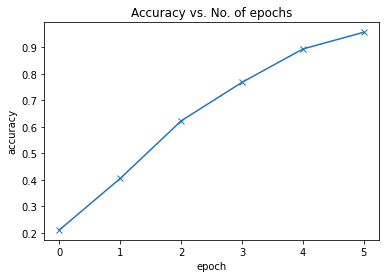

In [36]:
plot_accuracies(history)

## Validation loss

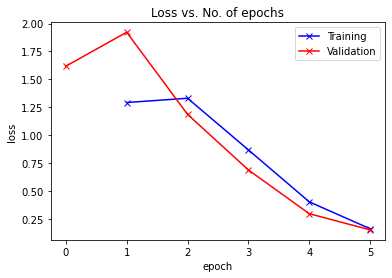

In [37]:
plot_losses(history)

## Learning Rate overtime

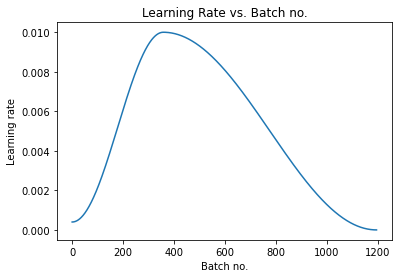

In [38]:
plot_lrs(history)

# 🧪 Testing model on test data 🧪

**We only have 33 images in test data, so let's check the model on all images**

In [46]:
test_dir = "../input/skin-data/data/test"
test = ImageFolder(test_dir, transform=transform)
test_dl = DataLoader(test, batch_size, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [40]:
test_images = sorted(os.listdir(test_dir + '/acne')) # since images in test folder are in alphabetical order
test_images

['150__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 '152__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 '172__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 '178__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 '195__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300149__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300151__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300166__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300176__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_0300179__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_100400148__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_100400176__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-0350_100400189__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg',
 'Crop-100350_100300169_

In [41]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: 150__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis


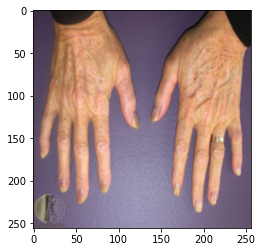

In [42]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [43]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: 150__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis
Label: 152__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis
Label: 172__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis
Label: 178__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis
Label: 195__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis
Label: Crop-0350_0300149__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis
Label: Crop-0350_0300151__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis
Label: Crop-0350_0300166__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis
Label: Crop-0350_0300176__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg , Predicted: Nail_psoriasis
Label: Crop-0350_0300179__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsI

IndexError: list index out of range

Test Loss: 0.1226, Test Accuracy: 0.9707
Confusion Matrix:
[[247   3   3   0   0]
 [  2 309   3   3   0]
 [  2   3 193   1   2]
 [  0   0   2 112   1]
 [  0   0   3   0  67]]


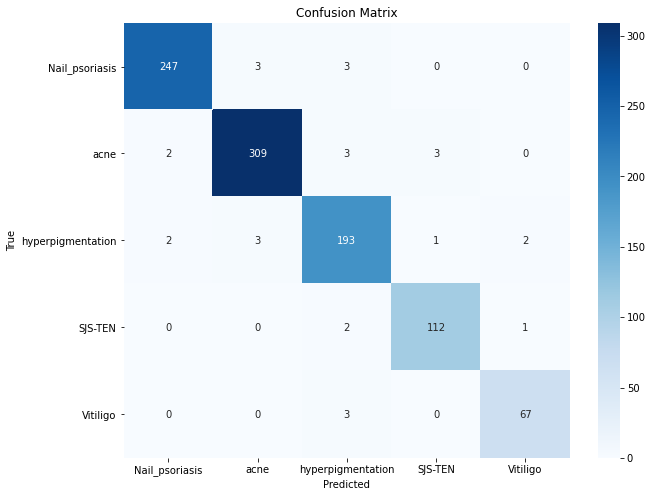

Classification Report:
                   precision    recall  f1-score   support

   Nail_psoriasis       0.98      0.98      0.98       253
             acne       0.98      0.97      0.98       317
hyperpigmentation       0.95      0.96      0.95       201
          SJS-TEN       0.97      0.97      0.97       115
         Vitiligo       0.96      0.96      0.96        70

         accuracy                           0.97       956
        macro avg       0.97      0.97      0.97       956
     weighted avg       0.97      0.97      0.97       956



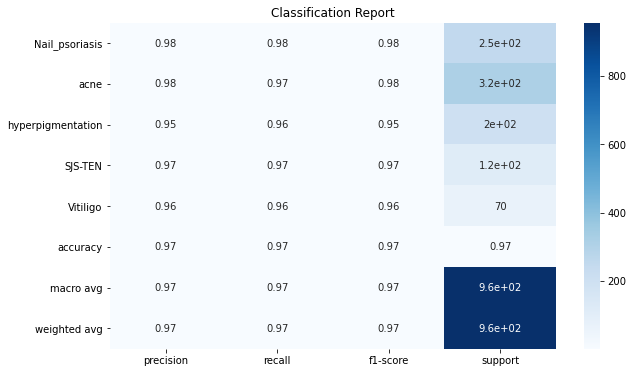

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Evaluate the model on the GPU
model.eval()
with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []

    total_loss = 0
    total_accuracy = 0

    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        test_outputs = model(images)
        test_loss = F.cross_entropy(test_outputs, labels)  # Calculate loss
        total_loss += test_loss.item()

        accuracy = (test_outputs.argmax(dim=1) == labels).float().mean()
        total_accuracy += accuracy.item()

        # Collect predictions and true labels for confusion matrix
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(test_outputs.argmax(dim=1).cpu().numpy())
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_dl)
    avg_accuracy = total_accuracy / len(test_dl)

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}')
    # Convert to numpy arrays for further analysis
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=diseases, yticklabels=diseases)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification report
    class_report = classification_report(all_true_labels, all_predicted_labels, target_names=diseases)
    print("Classification Report:")
    print(class_report)

    # Plot classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame.from_dict(classification_report(all_true_labels, all_predicted_labels, target_names=diseases, output_dict=True)).T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.show()

**We can see that the model predicted all the test images perfectly!!!!**

# Saving the model

**There are several ways to save the model in Pytorch, following are the two most common ways**

1. **Save/Load `state_dict` (Recommended)**

When saving a model for inference, it is only necessary to save the trained model’s learned parameters. Saving the model’s `state_dict` with the `torch.save()` function will give you the most flexibility for restoring the model later, which is why it is the recommended method for saving models.

A common PyTorch convention is to save models using either a `.pt` or `.pth` file extension.

Remember that you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

In [ ]:
# saving to the kaggle working directory
PATH = './skin-disease-model.pth'  
torch.save(model.state_dict(), PATH)

2. **Save/Load Entire Model**

This save/load process uses the most intuitive syntax and involves the least amount of code. Saving a model in this way will save the entire module using Python’s [pickle](https://docs.python.org/3/library/pickle.html) module. The disadvantage of this approach is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved. The reason for this is because pickle does not save the model class itself. Rather, it saves a path to the file containing the class, which is used during load time. Because of this, your code can break in various ways when used in other projects or after refactors.

In [ ]:
# saving the entire model to working directory
PATH = './skin-disease-model-complete.pth'
torch.save(model, PATH)

# Conclusion

ResNets perform significantly well for image classification when some of the parameters are tweaked and techniques like scheduling learning rate, gradient clipping and weight decay are applied. The model is able to predict every image in test set perfectly without any errors !!!!

# References
- [CIFAR10 ResNet Implementation](https://jovian.ai/aakashns/05b-cifar10-resnet)
- [PyTorch docs](https://pytorch.org/)


#### Hope you all learned something from this kernel. Do upvote if you find this useful.

#### Happy Learning....

#### Catch you guys on the next one

#### Peace ✌️